# Vectorized 2D Feature Detection
## Team LeakSeek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2 as cv

### Constants

In [2]:
# File Paths
MANIFOLD_IMG_PATH = 'manifold.png'
FEATURE_IMG_PATH = 'feature.png'

# Vectorization Hyperparameters
NEIGHBORHOOD_SIZE = 3
EMPTY_COLOR_THRESH = 254
ZERO_DIRECTION_THRESH = NEIGHBORHOOD_SIZE

# Comparison Hyperparameters
DIFF_THRESH = 25000

### Read Manifold and Reference Feature Images

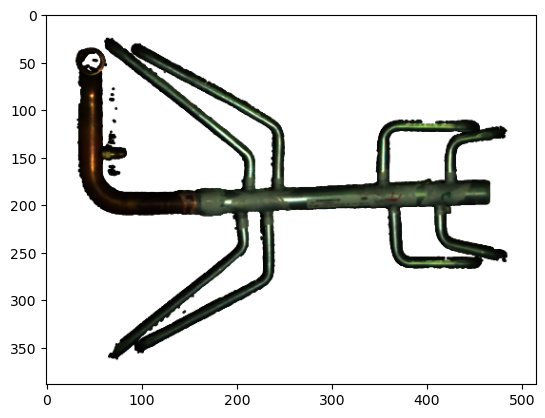

In [3]:
manifold_orig = cv.imread(MANIFOLD_IMG_PATH)
manifold_orig = cv.cvtColor(manifold_orig, cv.COLOR_BGR2RGB)
plt.imshow(manifold_orig)

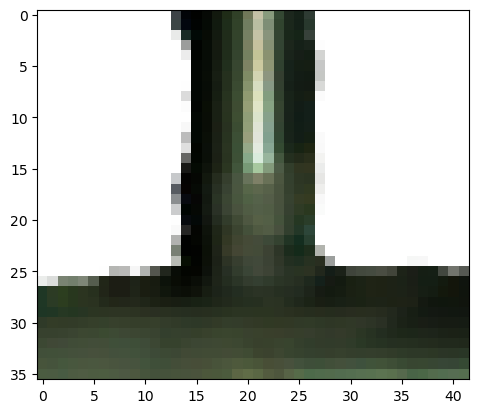

In [4]:
feature_orig = cv.imread(FEATURE_IMG_PATH)
feature_orig = cv.cvtColor(feature_orig, cv.COLOR_BGR2RGB)
plt.imshow(feature_orig)

In [5]:
# Convert manifold and reference feature images to grayscale for (simpler) subsequent processing.
manifold_gray = cv.cvtColor(manifold_orig, cv.COLOR_RGB2GRAY)
feature_gray = cv.cvtColor(feature_orig, cv.COLOR_RGB2GRAY)

### Step 1: Vectorization

In [6]:
# Colors in a neighborhood centered at the passed (x, y).
# ***For Visualization / Debugging Purposes Only***
def draw_neighborhood(x_centroid, y_centroid, color, img):
    min_x = max(0, x_centroid-NEIGHBORHOOD_SIZE)
    max_x = min(len(img[0])-1, x_centroid+NEIGHBORHOOD_SIZE)
    min_y = max(0, y_centroid-NEIGHBORHOOD_SIZE)
    max_y = min(len(img)-1, y_centroid+NEIGHBORHOOD_SIZE)
    
    for x in range(min_x, max_x+1):
        for y in range(min_y, max_y+1):
            img[y, x] = color
    
    return img

In [7]:
def add_vectors(v1, v2):
    return {'x': v1['x'] + v2['x'], 'y': v1['y'] + v2['y']}


# Determines if point is outside the passed image's boundaries.
#   If so, take the nearest pixel's value.
# Without this, the image edges will have skewed vector directions due to the missing (out of bounds) neighborhood portion.
def get_out_of_bounds_vector_ref(x, y, img):
    if x < 0:
        if y < 0:
            # Out of bounds at... left, top --> take 0,0
            return [0, 0]
        elif y > len(img)-1:
            # Out of bounds at... left, bottom --> take 0,len(img)-1
            return [0, len(img)-1]
        else:
            # Out of bounds at... left --> take 0,y
            return [0, y]
    elif x > len(img[0])-1:
        if y < 0:
            # Out of bounds at... right, top --> take len(img[0])-1,0
            return [len(img[0])-1, 0]
        elif y > len(img)-1:
            # Out of bounds at... right, bottom --> take len(img[0])-1,len(img)-1
            return [len(img[0])-1, len(img)-1]
        else:
            # Out of bounds at... right --> take len(img[0])-1,y
            return [len(img[0])-1, y]
    elif y < 0:
        # Out of bounds at... top --> take x,0
        return [x, 0]
    elif y > len(img)-1:
        # Out of bounds at... bottom --> take x,len(img)-1
        return [x, len(img)-1]
    else:
        # Passed point is within the image's boundaries, so return empty array to signify this.
        return []
    

# Calculates the neighborhood and superposition vector at a given (x, y) point.
def calculate_neighborhood_vector(x_centroid, y_centroid, img):
    # Note: The neighborhood is simply a cube, with centroid (x, y) and width/height of NEIGHBORHOOD_SIZE*2+1.
    x1 = x_centroid - NEIGHBORHOOD_SIZE
    y1 = y_centroid - NEIGHBORHOOD_SIZE
    
    x2 = x_centroid + NEIGHBORHOOD_SIZE
    y2 = y_centroid + NEIGHBORHOOD_SIZE
    
    # At each point in neighborhood, calculate vector from centroid, if not empty, and calculate
    #   superposition vector along the way.
    vector = {'x': 0, 'y': 0}
    vector_init = True
    for x in range(x1, x2+1):
        for y in range(y1, y2+1):
            # Determine if out of bounds; if so, then take the nearest pixel's value.
            ref = get_out_of_bounds_vector_ref(x, y, img)
            if ref != []:
                # Verify that reference pixel is not empty. Move onto next neighbor if so.
                if img[ref[1], ref[0]] > EMPTY_COLOR_THRESH:
                    continue
            else:
                # Verify that neighbor pixel is not empty. Move onto next neighbor if so.
                if img[y, x] > EMPTY_COLOR_THRESH:
                    continue

            # Make points relative to (x_centroid, y_centroid) being the origin (0, 0). This is for vector operations.
            x_relative = x - x_centroid
            y_relative = y - y_centroid

            if vector_init:
                # First neighbor, so need to initialize superposition vector.
                vector_init = False
                vector = {'x': x_relative, 'y': y_relative}
            else:
                # Add "neighbor -> centroid" vector to superposition vector.
                new_vector = {'x': x_relative, 'y': y_relative}
                vector = add_vectors(vector, new_vector)
            
    return vector

In [8]:
# Determines the "sign" of one of a vector's axes.
def get_vector_axis_sign(axis_value, enforce_zero_strictly=False):
    # Note: When enforce_zero_strictly is False, if the vector's direction is "close" to zero (as defined by the
    #   ZERO_DIRECTION_THRESH), then classify its direction as zero. This helps fight against noise / slight
    #   imperfections in the image.
    if (enforce_zero_strictly == True and axis_value == 0) or (enforce_zero_strictly == False and axis_value <= ZERO_DIRECTION_THRESH and axis_value >= -ZERO_DIRECTION_THRESH):
        return '0'
    elif axis_value > 0:
        return '+'
    elif axis_value < 0:
        return '-'
    else:
        return 'E' # Error


# Retrieves the color for a given vector's direction.
def get_color_by_signs(x_sign, y_sign):
    color = (255, 255, 255)
    if x_sign == '+':
        if y_sign == '+':
            color = (0, 255, 0) # Green
        elif y_sign == '-':
            color = (175, 0, 255) # Purple
        elif y_sign == '0':
            color = (0, 255, 255) # Sky Blue
    elif x_sign == '-':
        if y_sign == '+':
            color = (255, 150, 0) # Orange
        elif y_sign == '-':
            color = (140, 100, 75) # Brown
        elif y_sign == '0':
            color = (100, 180, 130) # Teal
    elif x_sign == '0':
        if y_sign == '+':
            color = (0, 0, 255) # Blue
        elif y_sign == '-':
            color = (0, 150, 0) # Dark Green
        elif y_sign == '0':
            color = (255, 255, 0) # Yellow
    
    return color


# Generalizes neighborhood by assigning a color based on the passed superposition vector's direction.
def generalize_neighborhood(vector):
    # Determine "sign" of vector's (x, y) components.
    #   Possible (x, y) "sign" combinations: ++, -+, +-, --, 00, 0+, 0-, +0, -0
    x = get_vector_axis_sign(vector['x'])
    y = get_vector_axis_sign(vector['y'])
    
    # Retrieve the color for the superposition vector's direction.
    color = get_color_by_signs(x, y)
    
    return color

In [9]:
# Vectorizes the given image, calculating neighborhood superposition vectors for each pixel, then saving those
#   superposition vectors' directions by visualizing them with different colors.
def vectorize_image(img_gray, img_color):
    # Calculate and visualize superposition vector for each pixel in image.
    for x in range(len(img_gray[0])):
        for y in range(len(img_gray)):
            vector = calculate_neighborhood_vector(x, y, img_gray)
            color = generalize_neighborhood(vector)
            img_color[y, x] = color
    
    return img_color

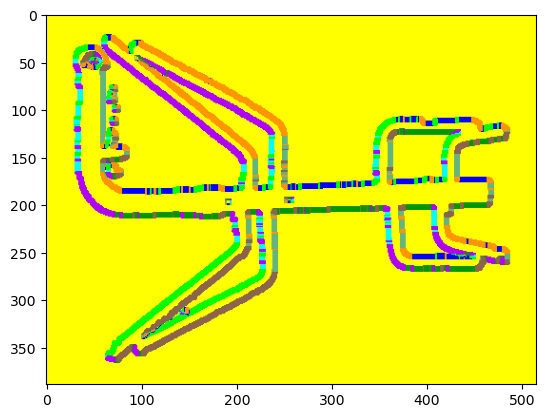

In [10]:
manifold_vectorized = manifold_orig.copy()
manifold_vectorized = vectorize_image(manifold_gray, manifold_vectorized)
plt.imshow(manifold_vectorized)

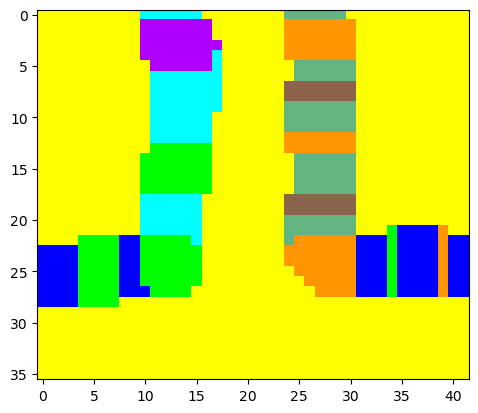

In [11]:
feature_vectorized = feature_orig.copy()
feature_vectorized = vectorize_image(feature_gray, feature_vectorized)
plt.imshow(feature_vectorized)

### Step 2: Reference Feature / Manifold Comparison
Find the reference features in the manifold image by comparing vectors.

In [12]:
""" TODO: Add support for 90 and 270 degree rotation. """

# Compute the superposition vector counterpart for rotated orientation.
def get_color_counterpart(color):
    """ TODO: Currently hardcoding counterparts; when generalizing to 90 and 270 degrees, fix this. """
    color = tuple(color)
    if color == (0, 255, 0):
        new_vector = {'x': -1, 'y': -1}
    elif color == (175, 0, 255):
        new_vector = {'x': -1, 'y': 1}
    elif color == (0, 255, 255):
        new_vector = {'x': -1, 'y': 0}
    elif color == (255, 150, 0):
        new_vector = {'x': 1, 'y': -1}
    elif color == (140, 100, 75):
        new_vector = {'x': 1, 'y': 1}
    elif color == (100, 180, 130):
        new_vector = {'x': 1, 'y': 0}
    elif color == (0, 0, 255):
        new_vector = {'x': 0, 'y': -1}
    elif color == (0, 150, 0):
        new_vector = {'x': 0, 'y': 1}
    elif color == (255, 255, 0):
        new_vector = {'x': 0, 'y': 0}
        
    x = get_vector_axis_sign(new_vector['x'], True)
    y = get_vector_axis_sign(new_vector['y'], True)
    
    color = get_color_by_signs(x, y)
    
    return color


# Rotates vectorized image so that a reference feature can be compared at different orientations.
def rotate_vectorized_image(img):
    # Physically rotate image.
    img_rotated = cv.rotate(img, cv.ROTATE_180)
    
    # Convert all superposition vectors to their rotated counterparts.
    for x in range(len(img_rotated[0])):
        for y in range(len(img_rotated)):
            color = img_rotated[y, x]
            img_rotated[y, x] = get_color_counterpart(color)

    return img_rotated

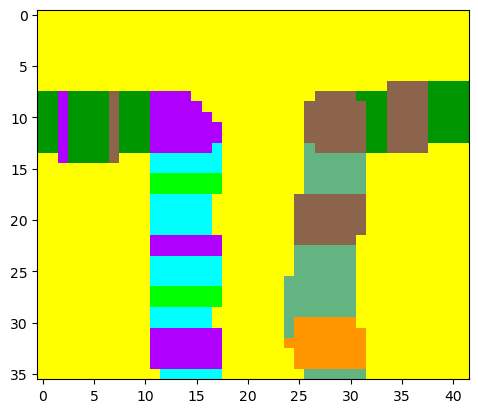

In [13]:
feature_vectorized_rotated = rotate_vectorized_image(feature_vectorized)
plt.imshow(feature_vectorized_rotated)

In [14]:
# Go pixel-by-pixel through the manifold image, then determine match percentages with feature being compared to.
points_of_interest = []
points_of_interest_data = []
for x in range(len(manifold_vectorized[0])):
    for y in range(len(manifold_vectorized)):
        # Skip if comparison will be out of bounds in manifold image.
        if ((y + len(feature_vectorized)) > len(manifold_vectorized)-1) or ((x + len(feature_vectorized[0])) > len(manifold_vectorized[0])-1):
            continue
        
        # Extract "window" of manifold image to compare with reference feature.
        extraction = manifold_vectorized[y:len(feature_vectorized)+y, x:len(feature_vectorized[0])+x]
        
        # Compare features by subtracting the window by the reference feature then evaluating the sum of the "difference" image.
        """ TODO: Generalize the below code to support 90 and 270 degree feature rotation comparison as well. """
        diff = cv.subtract(extraction, feature_vectorized)
        diff = cv.cvtColor(diff, cv.COLOR_BGR2GRAY)
        diff_sum = 0
        for i in range(len(diff[0])):
            for j in range(len(diff)):
                diff_sum += diff[j, i]
                
        diff_rotated = cv.subtract(extraction, feature_vectorized_rotated)
        diff_rotated = cv.cvtColor(diff_rotated, cv.COLOR_BGR2GRAY)
        diff_rotated_sum = 0
        for i in range(len(diff_rotated[0])):
            for j in range(len(diff_rotated)):
                diff_rotated_sum += diff_rotated[j, i]
                
        # If the difference between the reference feature and manifold window are low enough, count it as a detection.
        if diff_sum < DIFF_THRESH or diff_rotated_sum < DIFF_THRESH:
            points_of_interest.append('({}, {}): {} {}'.format(x, y, diff_sum, diff_rotated_sum))
            points_of_interest_data.append([x, y])
    print('\r', 'Progress: {}%'.format(str(int(x / int(len(manifold_vectorized[0])-1) * 100))), end='')
print(points_of_interest)

 Progress: 100%['(49, 161): 24267 46979', '(50, 161): 24419 46331', '(191, 158): 24728 46775', '(192, 157): 22896 47410', '(192, 158): 20772 47692', '(193, 156): 24288 48182', '(193, 157): 21563 49352', '(193, 158): 19281 49559', '(193, 159): 23360 49525', '(210, 196): 48754 24042', '(210, 197): 48248 20173', '(210, 198): 47292 20872', '(211, 196): 47040 22333', '(211, 197): 46526 18955', '(211, 198): 45378 19114', '(212, 196): 45386 24543', '(212, 197): 44811 21659', '(212, 198): 43647 21912', '(221, 157): 22884 47312', '(222, 156): 19631 45780', '(222, 157): 13802 46499', '(222, 158): 19266 48225', '(223, 155): 19369 46790', '(223, 156): 10781 47297', '(223, 157): 2034 48056', '(223, 158): 9759 49485', '(223, 159): 18697 50303', '(224, 156): 19349 48441', '(224, 157): 13001 49130', '(224, 158): 17894 50177', '(224, 159): 24759 50659', '(225, 157): 21496 50320', '(225, 158): 24983 51052', '(333, 152): 24881 46685', '(343, 192): 48660 23010', '(343, 193): 47927 21499', '(343, 194): 470

### Step 3: Visualize Detections

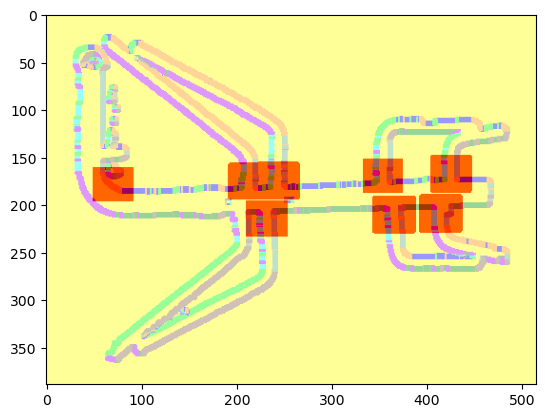

In [15]:
# This is just a naive way to get a blank version of the manifold figure for overlaying detections.
manifold_overlay = manifold_orig.copy()
for x in range(len(manifold_overlay[0])):
    for y in range(len(manifold_overlay)):
        manifold_overlay[y, x] = (255, 255, 255)

# Draw detection locations on blank overlay figure.
for pt in points_of_interest_data:
    for x in range(pt[0], len(feature_vectorized[0])+pt[0]):
        for y in range(pt[1], len(feature_vectorized)+pt[1]):
            manifold_overlay[y, x] = (255, 0, 0)
            
# Overlay detections onto the manifold image.
plt.imshow(manifold_vectorized)
plt.imshow(manifold_overlay, alpha=0.6)
plt.show()

### Extra Processing to Narrow Difference Comparison Results
Below was an attempt at utilizing the vector magnitudes to further narrow the results from the difference comparison.<br>
**Note: This might not be necessary based on the next solution improvements we come up with.**

Ignoring detection @ (49, 161). Vector: {'x': -268, 'y': 218}
Ignoring detection @ (50, 161). Vector: {'x': -272, 'y': 228}
Ignoring detection @ (210, 198). Vector: {'x': -178, 'y': -145}
Ignoring detection @ (221, 157). Vector: {'x': -39, 'y': 213}
Ignoring detection @ (222, 156). Vector: {'x': -11, 'y': 223}
Ignoring detection @ (222, 157). Vector: {'x': -10, 'y': 213}
Ignoring detection @ (222, 158). Vector: {'x': -9, 'y': 196}


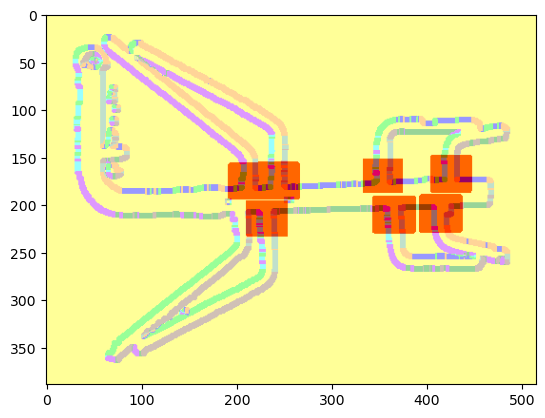

In [16]:
def get_vector_by_color(color):
    color = tuple(color) # Conversion needed for comparisons to RGB tuples.
    if color == (0, 255, 0):
        return {'x': 1, 'y': 1}
    elif color == (175, 0, 255):
        return {'x': 1, 'y': -1}
    elif color == (0, 255, 255):
        return {'x': 1, 'y': 0}
    elif color == (255, 150, 0):
        return {'x': -1, 'y': 1}
    elif color == (140, 100, 75):
        return {'x': -1, 'y': -1}
    elif color == (100, 180, 130):
        return {'x': -1, 'y': 0}
    elif color == (0, 0, 255):
        return {'x': 0, 'y': 1}
    elif color == (0, 150, 0):
        return {'x': 0, 'y': -1}
    elif color == (255, 255, 0):
        return {'x': 0, 'y': 0}
    
def compute_feature_vector(feature):
    # For each pixel, determine vector generalization, and add that to the overall vector.{}
    vector_init = True
    vector = {'x': 0, 'y': 0}
    for x in range(len(feature[0])):
        for y in range(len(feature)):
            if vector_init:
                vector_init = False
                vector = get_vector_by_color(feature[y, x])
            else:
                new_vector = get_vector_by_color(feature[y, x])
                vector = add_vectors(vector, new_vector)
    
    return vector

# This is just a naive way to get a blank version of the manifold figure for overlaying detections.
manifold_overlay = manifold_vectorized.copy()
for x in range(len(manifold_overlay[0])):
    for y in range(len(manifold_overlay)):
        manifold_overlay[y, x] = (255, 255, 255)

VECTOR_X_THRESH = 0
VECTOR_Y_THRESH = 150
        
# Draw detection locations on blank overlay figure.
for pt in points_of_interest_data:
    # Extract portion of manifold image to feature compare.
    extraction = manifold_vectorized[pt[1]:len(feature_vectorized)+pt[1], pt[0]:len(feature_vectorized[0])+pt[0]]
    vector = compute_feature_vector(extraction)
    
    # Note: These thresh values depend on feature being compared...
    if (vector['x'] > VECTOR_X_THRESH and vector['y'] > VECTOR_Y_THRESH) or (-vector['x'] > VECTOR_X_THRESH and -vector['y'] > VECTOR_Y_THRESH):
        # print(pt, vector)
        for x in range(pt[0], len(feature_vectorized[0])+pt[0]):
            for y in range(pt[1], len(feature_vectorized)+pt[1]):
                manifold_overlay[y, x] = (255, 0, 0)
    else:
        print('Ignoring detection @ ({}, {}). Vector: {}'.format(pt[0], pt[1], vector))
            
# Overlay detections onto the manifold image.
plt.imshow(manifold_vectorized)
plt.imshow(manifold_overlay, alpha=0.6)
plt.show()